<a href="https://colab.research.google.com/github/lydialydia-lydia/rwa-stablecoin-risk-spark/blob/main/02_solvency_stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!rm -rf rwa-stablecoin-risk-spark
!git clone https://github.com/lydialydia-lydia/rwa-stablecoin-risk-spark.git
%cd /content/rwa-stablecoin-risk-spark
!ls
!ls data

/content
Cloning into 'rwa-stablecoin-risk-spark'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 37 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 240.34 KiB | 4.29 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/rwa-stablecoin-risk-spark
01_data_fetch.ipynb  data  figures  LICENSE  notebooks	README.md
spark_assets_proxy.csv


In [2]:
import pandas as pd

tvl = pd.read_csv("data/spark_assets_proxy.csv")
tvl["date"] = pd.to_datetime(tvl["date"])
tvl.head()

,date,assets_proxy_usd
0,2023-05-01,31.0
1,2023-05-02,30.0
2,2023-05-03,31.0
3,2023-05-04,31.0
4,2023-05-05,31.0


In [3]:
A0 = float(tvl["assets_proxy_usd"].iloc[-1])   # latest proxy (USD)
A0

7354105917.9907

In [4]:
target_cr_now = 1.05
L0 = A0 / target_cr_now   # implied liabilities (USD)
L0

7003910398.08638

In [5]:
import numpy as np
import pandas as pd

rate_shocks_bp = np.array([0, 50, 100, 150, 200, 300])
haircuts = np.array([0.00, 0.02, 0.05, 0.10])   # liquidation/valuation friction

duration = 1.0   # simplified: short duration Treasury proxy

rows = []
for h in haircuts:
    for bp in rate_shocks_bp:
        dy = bp / 10_000
        A_stress = A0 * (1 - h) * (1 - duration * dy)
        CR = A_stress / L0
        rows.append([h, bp, A_stress, CR])

results = pd.DataFrame(rows, columns=["haircut", "rate_shock_bp", "asset_value_usd", "collateral_ratio"])
results

,haircut,rate_shock_bp,asset_value_usd,collateral_ratio
0,0.00,0,7.354106e+09,1.050000
1,0.00,50,7.317335e+09,1.044750
2,0.00,100,7.280565e+09,1.039500
3,0.00,150,7.243794e+09,1.034250
4,0.00,200,7.207024e+09,1.029000
5,0.00,300,7.133483e+09,1.018500
6,0.02,0,7.207024e+09,1.029000
7,0.02,50,7.170989e+09,1.023855
8,0.02,100,7.134954e+09,1.018710
9,0.02,150,7.098918e+09,1.013565


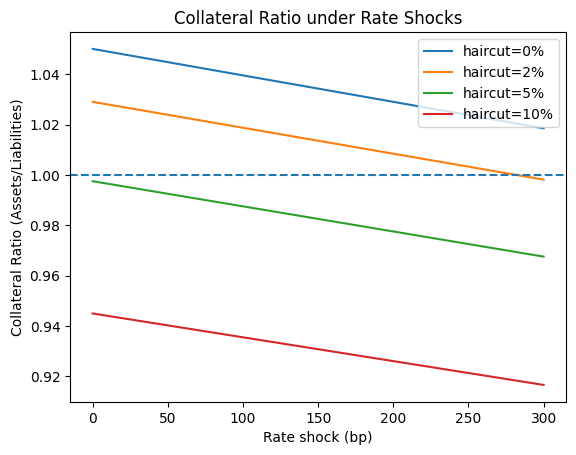

In [6]:
import matplotlib.pyplot as plt

# CR curve: by shock, one line per haircut
plt.figure()
for h in haircuts:
    sub = results[results["haircut"]==h].sort_values("rate_shock_bp")
    plt.plot(sub["rate_shock_bp"], sub["collateral_ratio"], label=f"haircut={h:.0%}")
plt.axhline(1.0, linestyle="--")
plt.xlabel("Rate shock (bp)")
plt.ylabel("Collateral Ratio (Assets/Liabilities)")
plt.title("Collateral Ratio under Rate Shocks")
plt.legend()
plt.show()

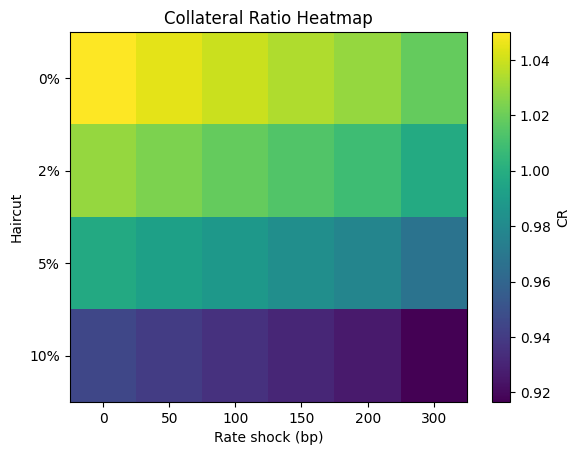

In [7]:
pivot = results.pivot(index="haircut", columns="rate_shock_bp", values="collateral_ratio")

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), [f"{h:.0%}" for h in pivot.index])
plt.xlabel("Rate shock (bp)")
plt.ylabel("Haircut")
plt.title("Collateral Ratio Heatmap")
plt.colorbar(label="CR")
plt.show()

In [8]:
import os
os.getcwd()

'/content/rwa-stablecoin-risk-spark'

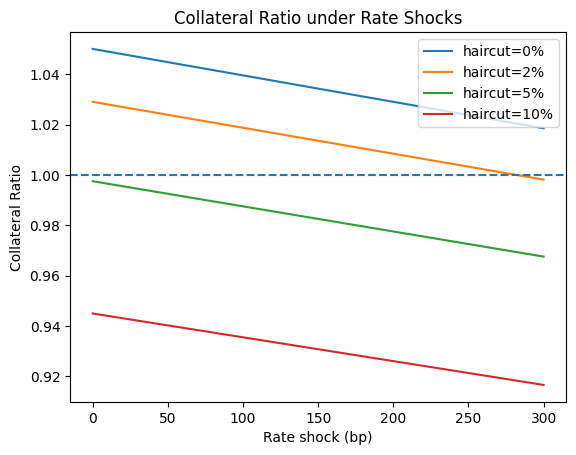

In [9]:
import os
import matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)

plt.figure()
for h in haircuts:
    sub = results[results["haircut"]==h].sort_values("rate_shock_bp")
    plt.plot(sub["rate_shock_bp"], sub["collateral_ratio"], label=f"haircut={h:.0%}")

plt.axhline(1.0, linestyle="--")
plt.xlabel("Rate shock (bp)")
plt.ylabel("Collateral Ratio")
plt.title("Collateral Ratio under Rate Shocks")
plt.legend()

plt.savefig(
    "figures/collateral_ratio_curve.png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()

In [10]:
from google.colab import files
files.download("figures/collateral_ratio_curve.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>